In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [90]:
# old decoder
old_decoder_casp = pd.read_csv("benchmark_data/final_1_casp/final_1_casp_scores.csv")
old_decoder_test = pd.read_csv("benchmark_data/final_1_test/final_1_test_scores.csv")

# prime darkness
# prime_darkness_casp = pd.read_csv("benchmark_data/prime_darkness_1_casp/prime_darkness_1_casp_scores.csv")
# prime_darkness_test = pd.read_csv("benchmark_data/prime_darkness_1_test/prime_darkness_1_test_scores.csv")

# beta = 0
beta_0_casp = pd.read_csv("benchmark_data/final_final_1_casp/final_final_1_casp_scores.csv")
beta_0_test = pd.read_csv("benchmark_data/final_final_1_test/final_final_1_test_scores.csv")

# beta = 1
beta_1_casp = pd.read_csv("benchmark_data/final_final_2_casp/final_final_2_casp_scores.csv")
beta_1_test = pd.read_csv("benchmark_data/final_final_2_test/final_final_2_test_scores.csv")

# bio2token
bio2token_casp = pd.read_csv("benchmark_data/bio2token_1_casp/bio2token_1_casp_scores.csv")
bio2token_test = pd.read_csv("benchmark_data/bio2token_1_test/bio2token_1_test_scores.csv")

# foldtoken
foldtoken_casp = pd.read_csv("benchmark_data/foldtoken_1_casp/foldtoken_1_casp_scores.csv")
foldtoken_test = pd.read_csv("benchmark_data/foldtoken_1_test/foldtoken_1_test_scores.csv")

# esmfold
esmfold_casp = pd.read_csv("benchmark_data/ESMFold_casp/ESMFold_casp_scores.csv")
esmfold_test = pd.read_csv("benchmark_data/ESMFold_test/ESMFold_test_scores.csv")

# prostt5 finalfinal model
prostt5_casp_1 = pd.read_csv("benchmark_data/0_final/prostt5_1_casp/prostt5_1_casp_scores.csv")
prostt5_test_1 = pd.read_csv("benchmark_data/0_final/prostt5_1_test/prostt5_1_test_scores.csv")

# prostt5_casp_2 = pd.read_csv("prostt5_2_casp/prostt5_2_casp_scores.csv")
# prostt5_test_2 = pd.read_csv("benchmark_data/prostt5_2_test/prostt5_2_test_scores.csv")

In [91]:
# Define the bootstrapping function
def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (1 - ci) / 2 * 100)
    upper = np.percentile(means, (1 + ci) / 2 * 100)
    return np.mean(means), lower, upper

In [92]:
def _default_colors(n):
    base = ["#4C78A8", "#59A14F", "#E45756", "#F28E2B", "#B279A2",
            "#76B7B2", "#EDC948", "#B07AA1", "#FF9DA6", "#9C755F"]
    if n <= len(base):
        return base[:n]
    # repeat if more models than base colors
    q, r = divmod(n, len(base))
    return (base * q) + base[:r]

def collect_data(metrics, dfs):
    """
    Args:
      metrics: list[str] columns to plot
      dfs: list[pd.DataFrame] one per model

    Returns:
      metric_data: dict(metric -> list of arrays per model in dfs order)
      model_data:  dict(model_idx -> dict(metric -> array))
    """
    # sanity: ensure all metrics exist
    for m in metrics:
        missing = [i for i, df in enumerate(dfs) if m not in df.columns]
        assert not missing, f"Metric '{m}' missing in dfs at indices: {missing}"

    metric_data = {m: [df[m].dropna().values for df in dfs] for m in metrics}
    model_data  = {i: {m: metric_data[m][i] for m in metrics} for i in range(len(dfs))}
    return metric_data, model_data

def plot_scores(metrics, dfs, model_names, colors=None,
                kind="box", layout="by_metric",   # layout: "by_metric" | "single_metric"
                fig=(8,6), dpi=180, out_path=None, single_metric_name=None,
                title=None, ylabel="Score"):
    """
    Plot grouped box/violin plots for arbitrary model/dataframe sets.

    metrics: list of metric column names
    dfs:     list of DataFrames (same order as model_names)
    model_names: list of model labels
    colors:  list of colors (optional; auto-picked if None)
    kind:    "box" or "violin"
    layout:
      - "by_metric": metrics on x, models grouped within each metric
      - "single_metric": models on x for the one metric 'single_metric_name'
    """
    assert kind in {"box", "violin"}
    assert len(dfs) == len(model_names), "dfs and model_names length must match"
    colors = colors or _default_colors(len(model_names))

    if layout == "single_metric":
        assert single_metric_name is not None and single_metric_name in metrics, \
            "Provide single_metric_name present in metrics for layout='single_metric'"

    metric_data, model_data = collect_data(metrics, dfs)

    plt.figure(figsize=fig, dpi=dpi)
    handles = []

    if layout == "by_metric":
        n_models = len(model_names)
        n_metrics = len(metrics)
        base_pos = np.arange(1, n_metrics + 1, dtype=float)
        group_width = 0.6
        width = group_width / n_models
        offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * width

        for i, (model, color) in enumerate(zip(model_names, colors)):
            data_i = [metric_data[m][i] for m in metrics]
            pos_i  = base_pos + offsets[i]

            if kind == "box":
                artists = plt.boxplot(
                    data_i, positions=pos_i, widths=width*0.85, patch_artist=True,
                    showfliers=True, notch=False, manage_ticks=False
                )
                for b in artists['boxes']:
                    b.set(facecolor=color, edgecolor="black", alpha=0.6, linewidth=1.2)
                for key in ('whiskers','caps','medians'):
                    for l in artists.get(key, []):
                        l.set(color="black", linewidth=1.0 if key!="medians" else 1.4)
                for f in artists.get('fliers', []):
                    f.set(marker='o', markersize=4, markerfacecolor=color,
                          markeredgecolor="black", alpha=0.8)
            else:
                vp = plt.violinplot(
                    data_i, positions=pos_i, widths=width*0.9,
                    showmeans=False, showmedians=True, showextrema=True
                )
                for body in vp['bodies']:
                    body.set(facecolor=color, edgecolor="black", alpha=0.6)
                vp['cmedians'].set(color="black")
                for k in ('cmins','cmaxes','cbars'):
                    if k in vp: vp[k].set(color="black")

            handles.append(Patch(facecolor=color, edgecolor="black", label=model, alpha=0.6))

        plt.xticks(base_pos, metrics)
        plt.xlim(base_pos[0]-0.8, base_pos[-1]+0.8)

    else:  # "single_metric"
        m = single_metric_name
        positions = np.arange(1, len(model_names)+1)
        series = [d[m] for d in model_data.values()]  # arrays per model index

        for pos, (model, color, data) in zip(positions, zip(model_names, colors, series)):
            if kind == "box":
                artists = plt.boxplot(
                    [data], positions=[pos], widths=0.6, patch_artist=True,
                    showfliers=True, notch=False
                )
                for b in artists['boxes']:
                    b.set(facecolor=color, edgecolor="black", alpha=0.6)
                for key in ('whiskers','caps','medians'):
                    for l in artists.get(key, []):
                        l.set(color="black", linewidth=1.2)
                for f in artists.get('fliers', []):
                    f.set(marker='o', markersize=4, markerfacecolor=color,
                          markeredgecolor="black", alpha=0.8)
            else:
                vp = plt.violinplot(
                    [data], positions=[pos], widths=0.6,
                    showmeans=False, showmedians=True, showextrema=True
                )
                for body in vp['bodies']:
                    body.set(facecolor=color, edgecolor="black", alpha=0.6)
                vp['cmedians'].set(color="black")
                for k in ('cmins','cmaxes','cbars'):
                    if k in vp: vp[k].set(color="black")

        plt.xticks(positions, model_names)
        plt.xlim(0.5, len(model_names)+0.5)
        ylabel = f"{m} Score"

    plt.ylabel(ylabel)
    if title: plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if layout == "by_metric":
        plt.legend(handles=handles, title="Model", loc='best')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()


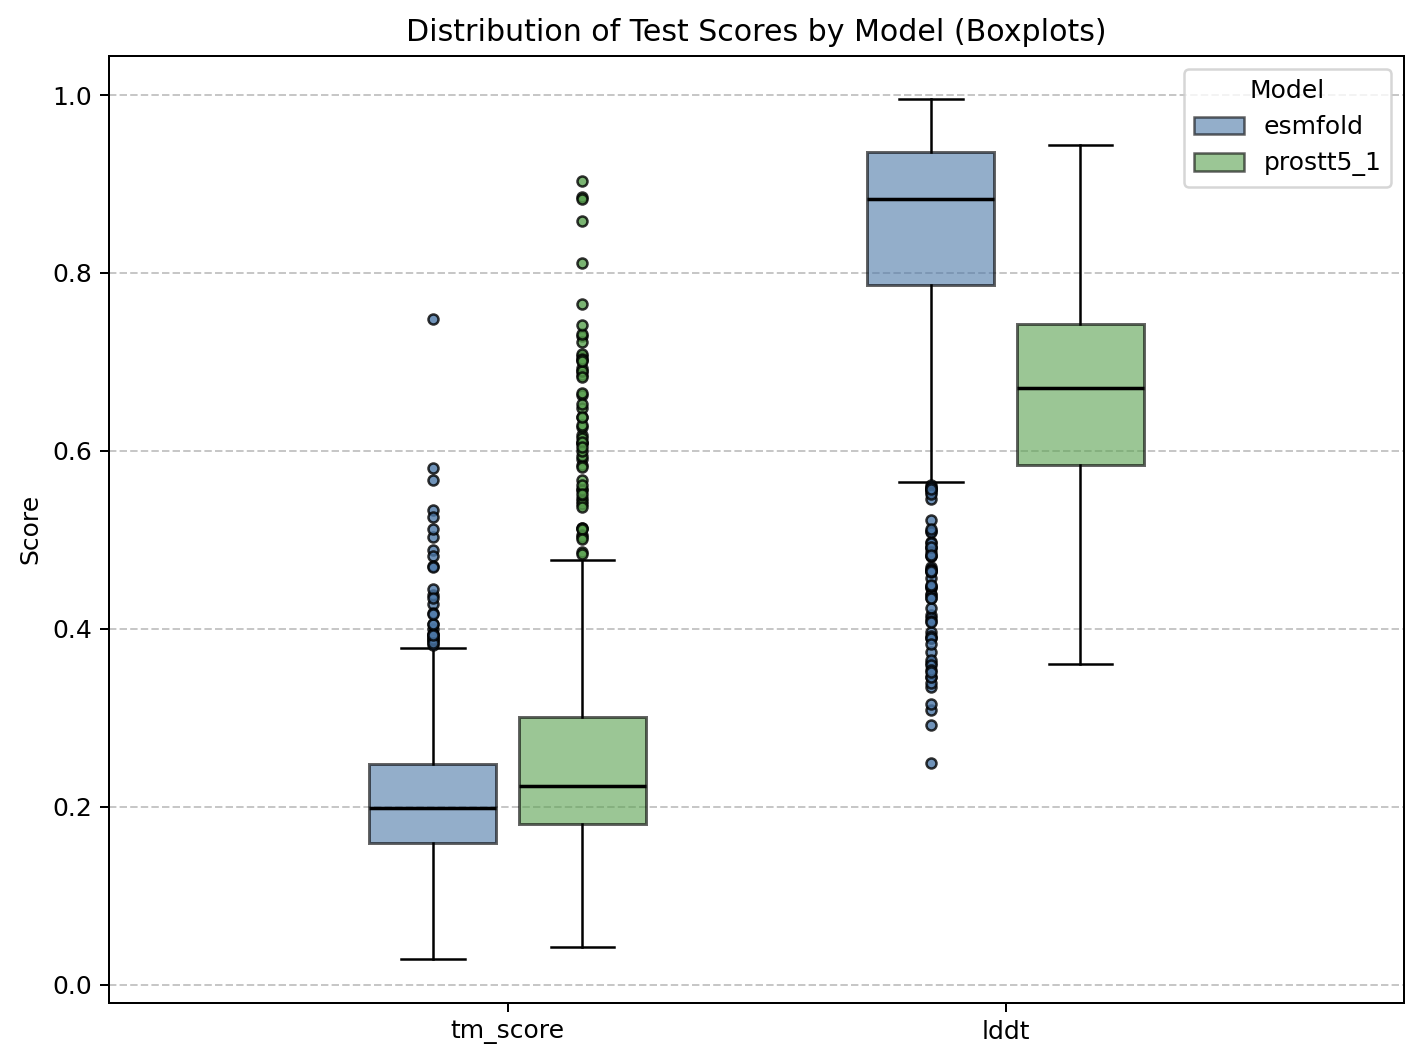

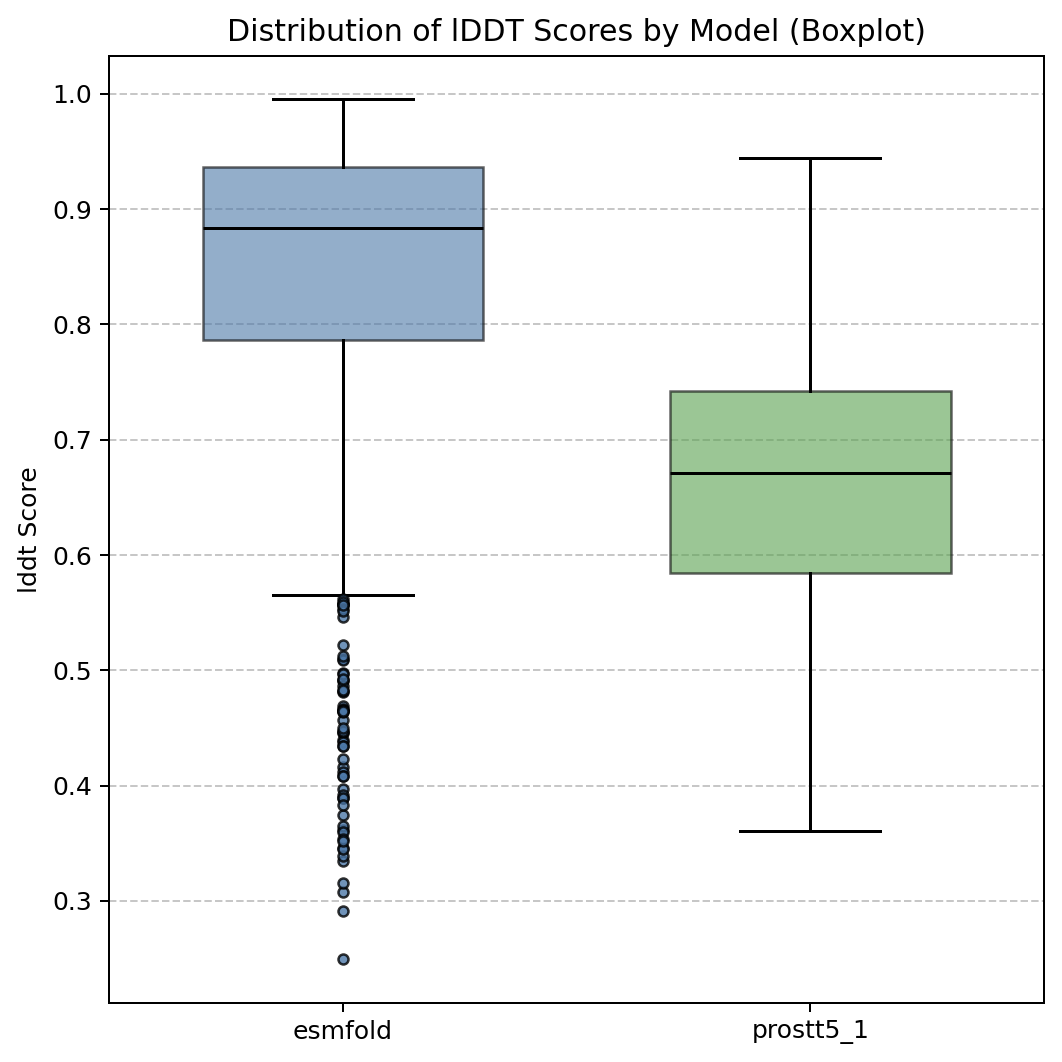

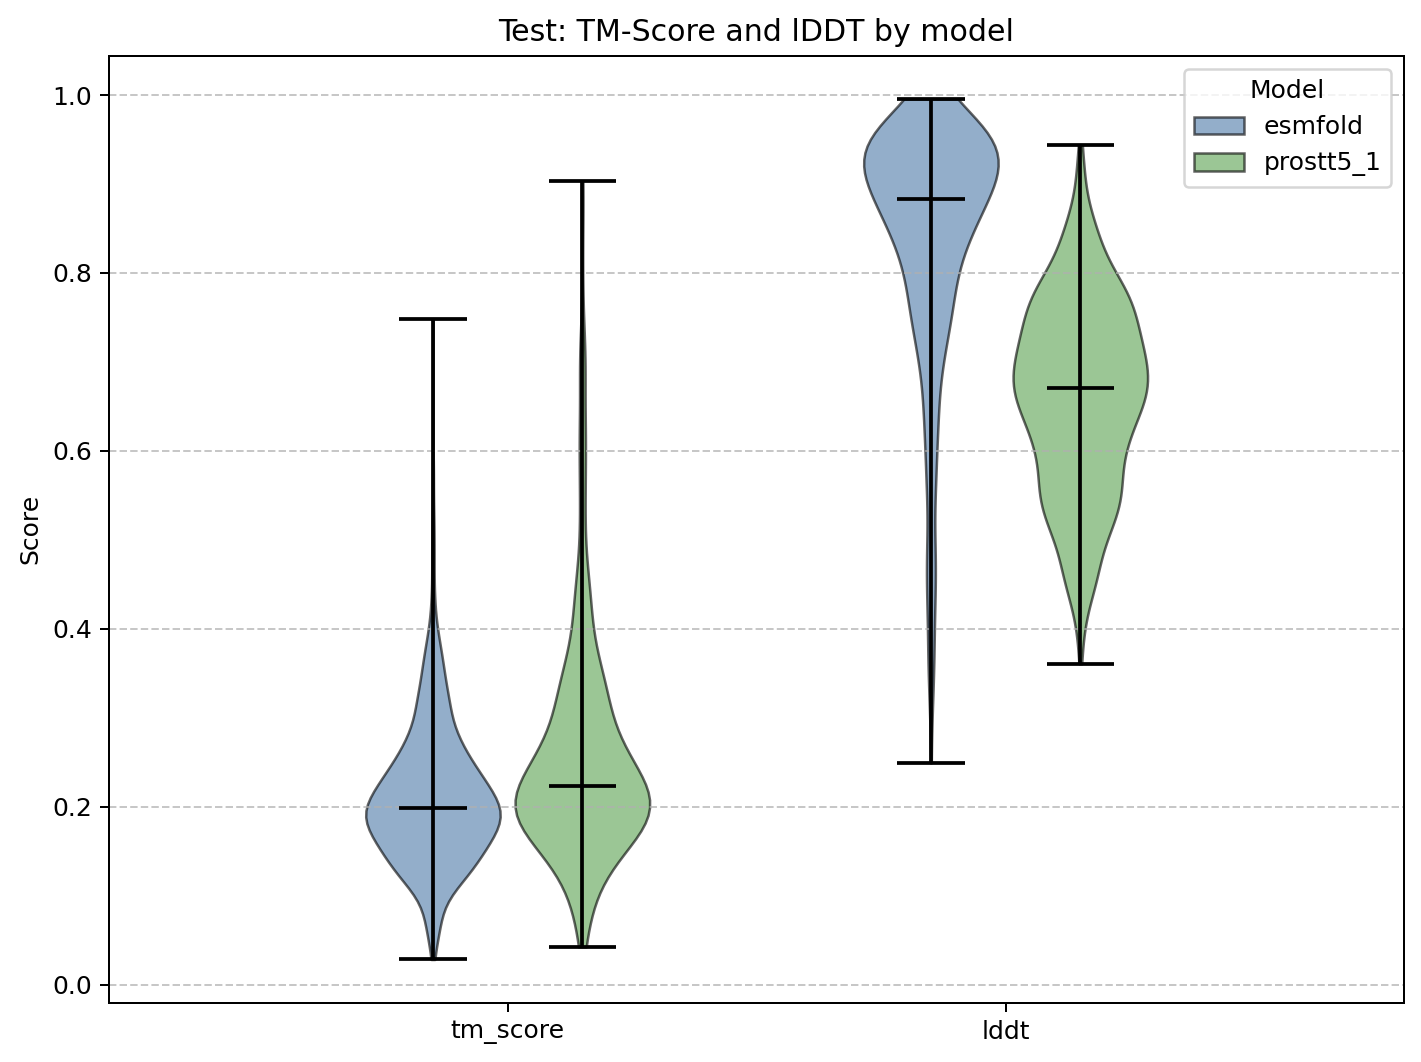

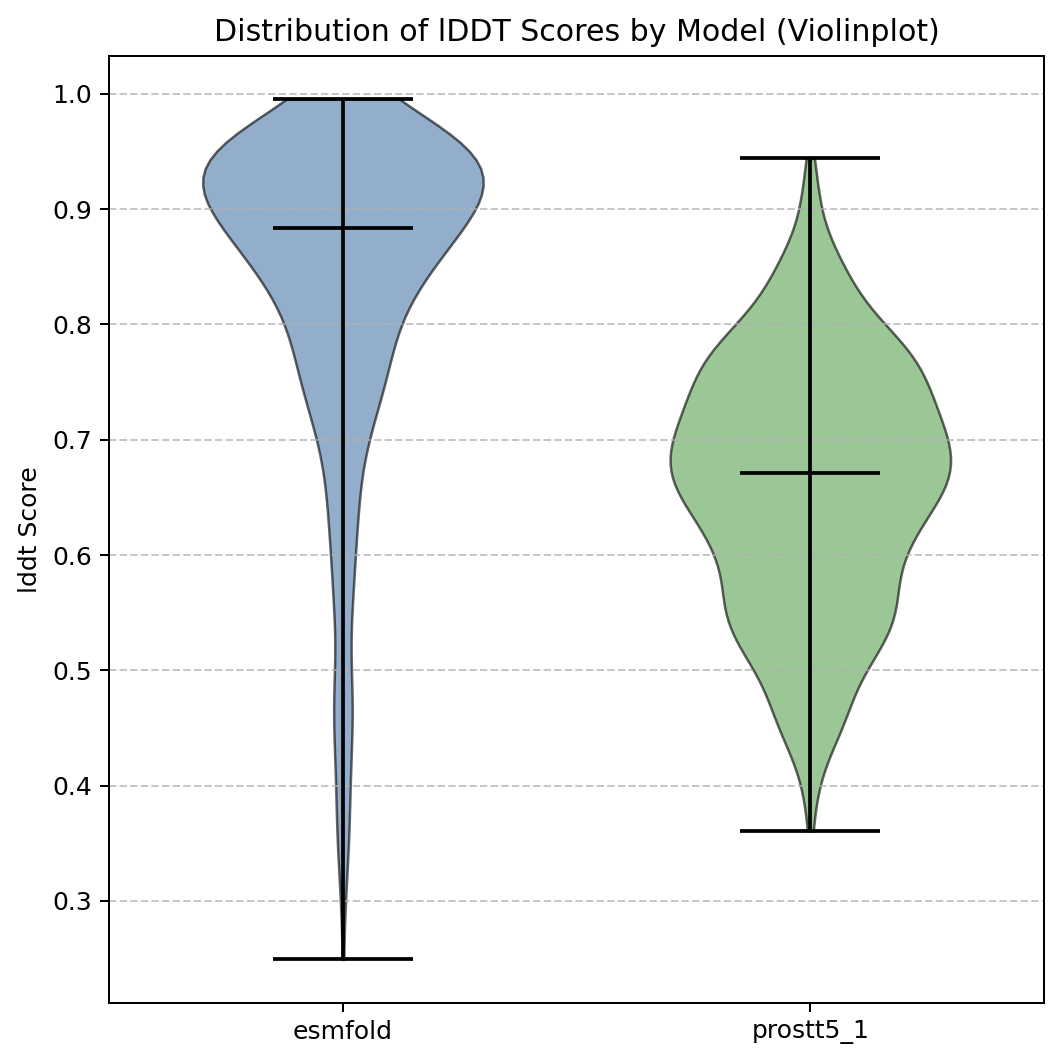

In [93]:
# TEST
test_metrics = ['tm_score','lddt']
test_dfs     = [esmfold_test, prostt5_test_1]
test_names   = ["esmfold", "prostt5_1"]

# 1) Grouped-by-metric BOX
plot_scores(
    metrics=test_metrics,
    dfs=test_dfs,
    model_names=test_names,
    kind="box",
    layout="by_metric",
    out_path="plots/final/box_test_compare.png",
    title="Distribution of Test Scores by Model (Boxplots)"
)

# 2) Single metric (lDDT) BOX, models on x
plot_scores(
    metrics=['lddt'],
    dfs=test_dfs,
    model_names=test_names,
    kind="box",
    layout="single_metric",
    single_metric_name='lddt',
    fig=(6,6),
    out_path="plots/final/box_test_lddt.png",
    title="Distribution of lDDT Scores by Model (Boxplot)"
)

# 3) Grouped-by-metric VIOLIN
plot_scores(
    metrics=test_metrics,
    dfs=test_dfs,
    model_names=test_names,
    kind="violin",
    layout="by_metric",
    out_path="plots/final/violin_test_compare.png",
    title="Test: TM-Score and lDDT by model"
)

# 4) Single metric (lDDT) VIOLIN, models on x
plot_scores(
    metrics=['lddt'],
    dfs=test_dfs,
    model_names=test_names,
    kind="violin",
    layout="single_metric",
    single_metric_name='lddt',
    fig=(6,6),
    out_path="plots/final/violin_test_lddt.png",
    title="Distribution of lDDT Scores by Model (Violinplot)"
)


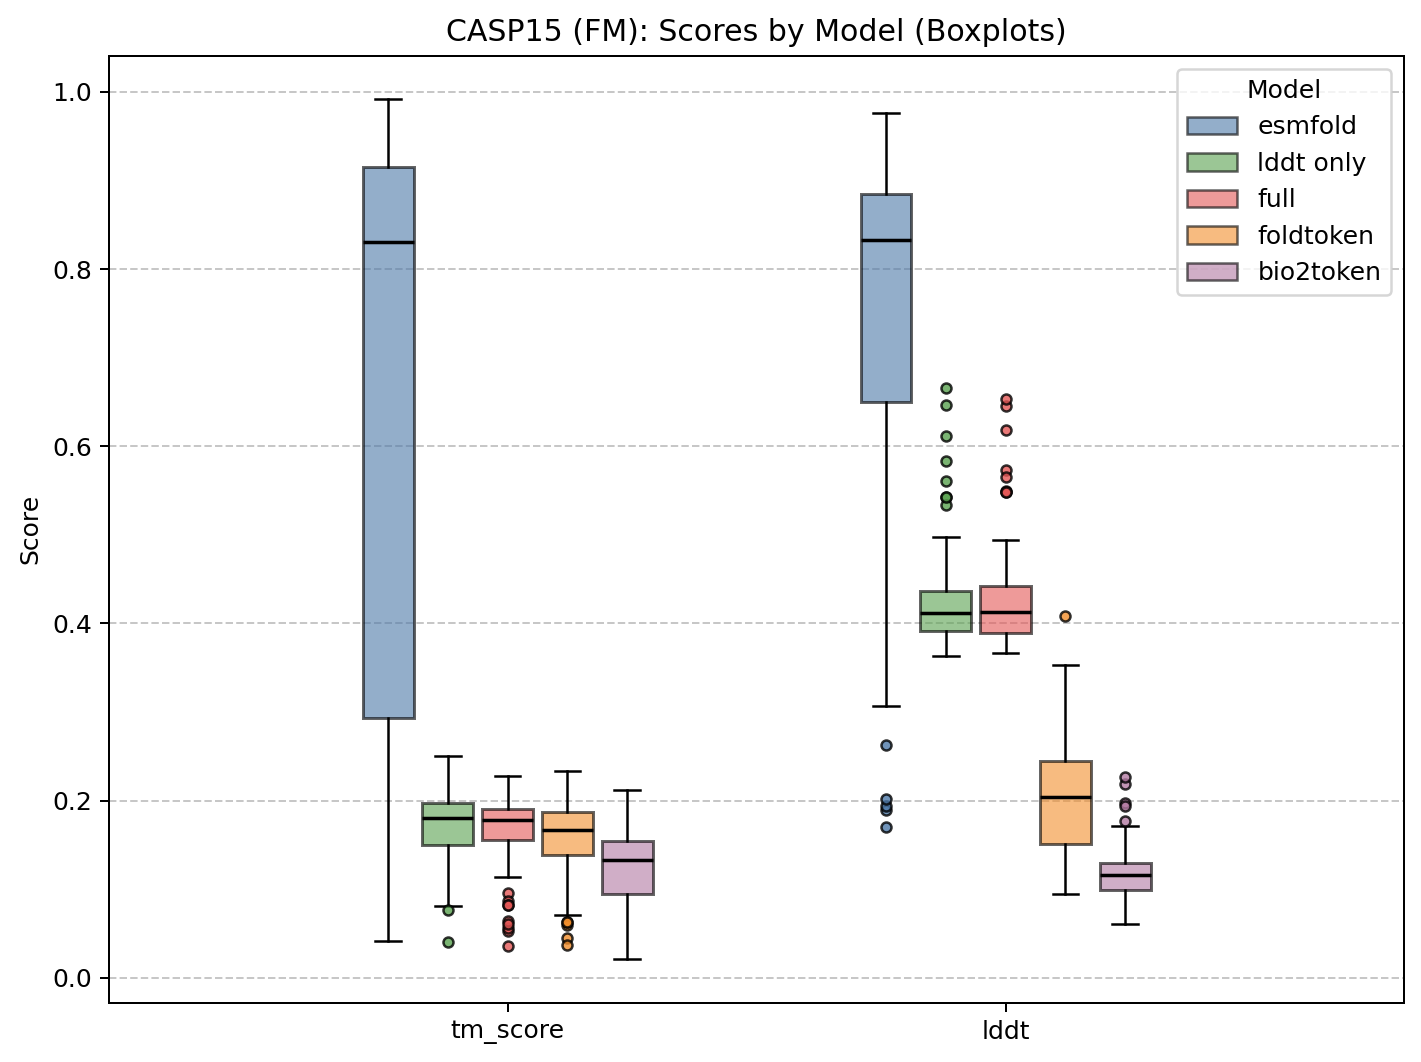

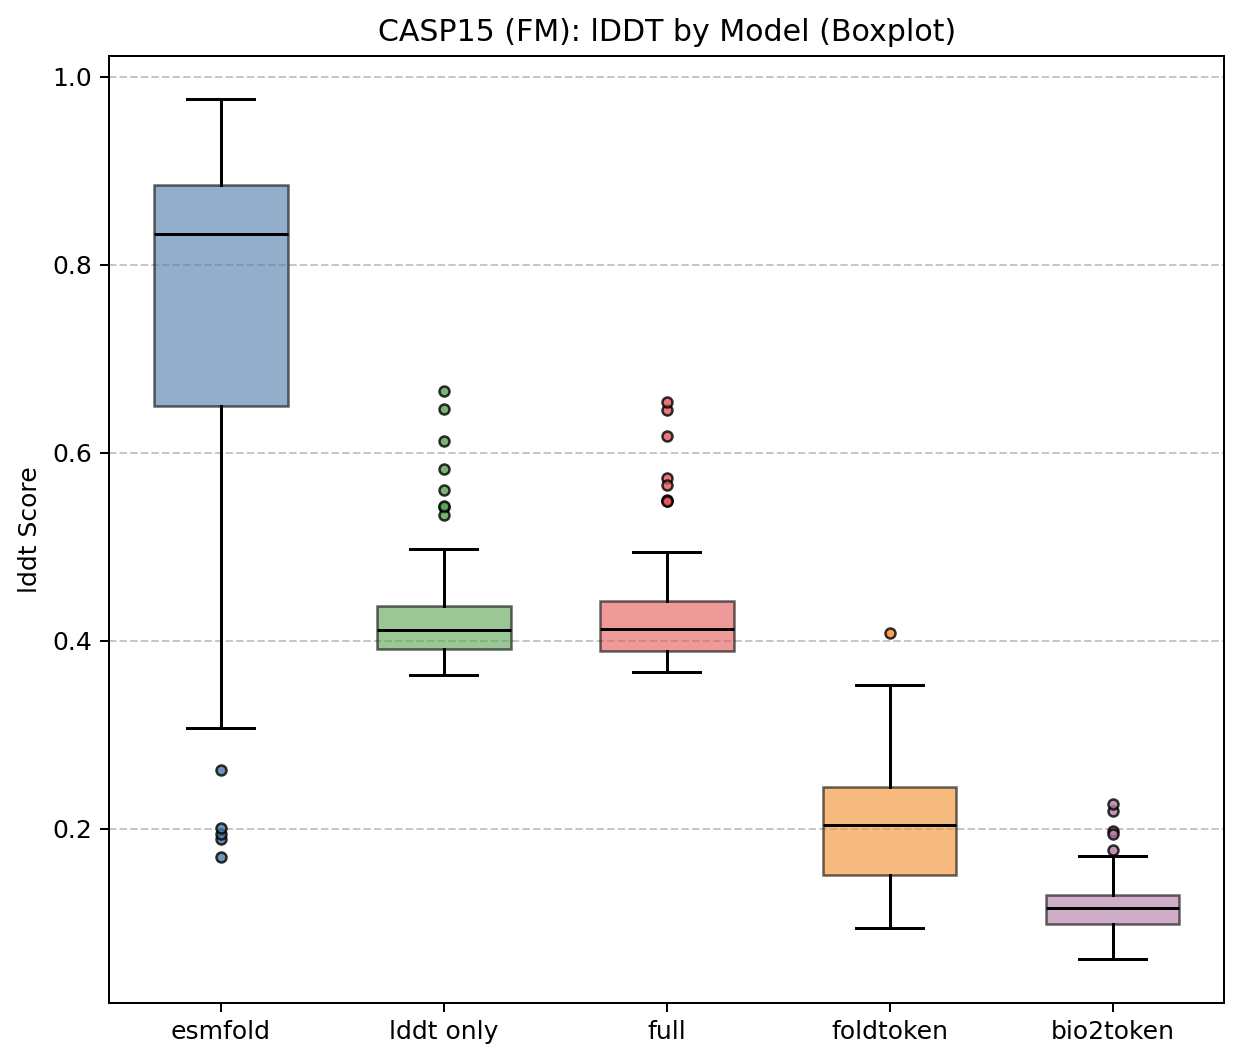

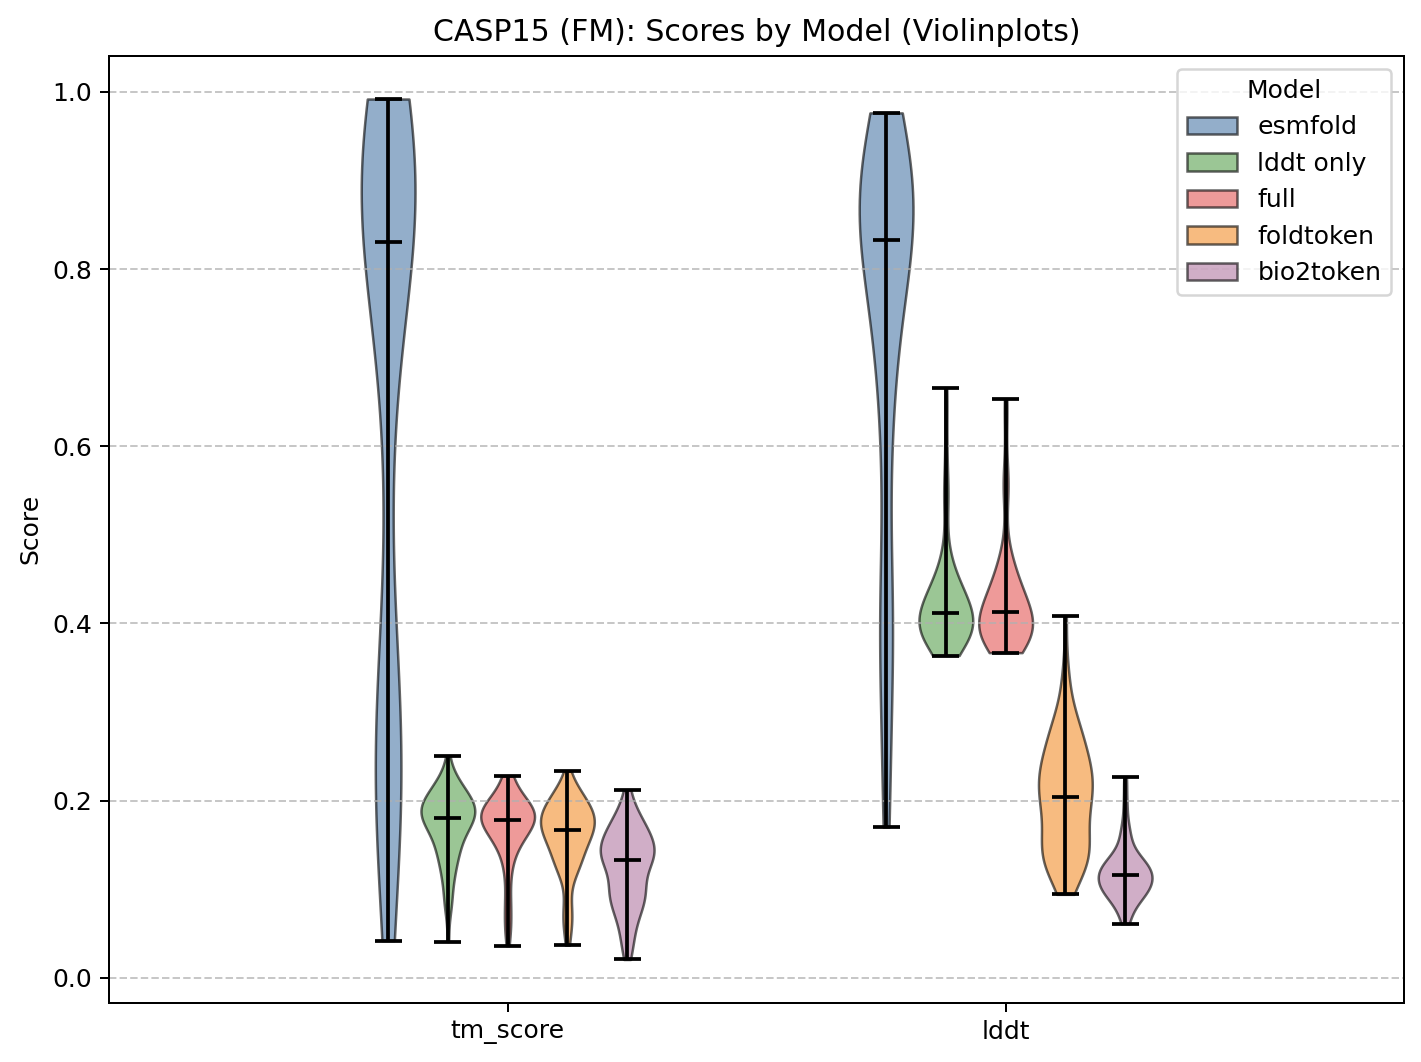

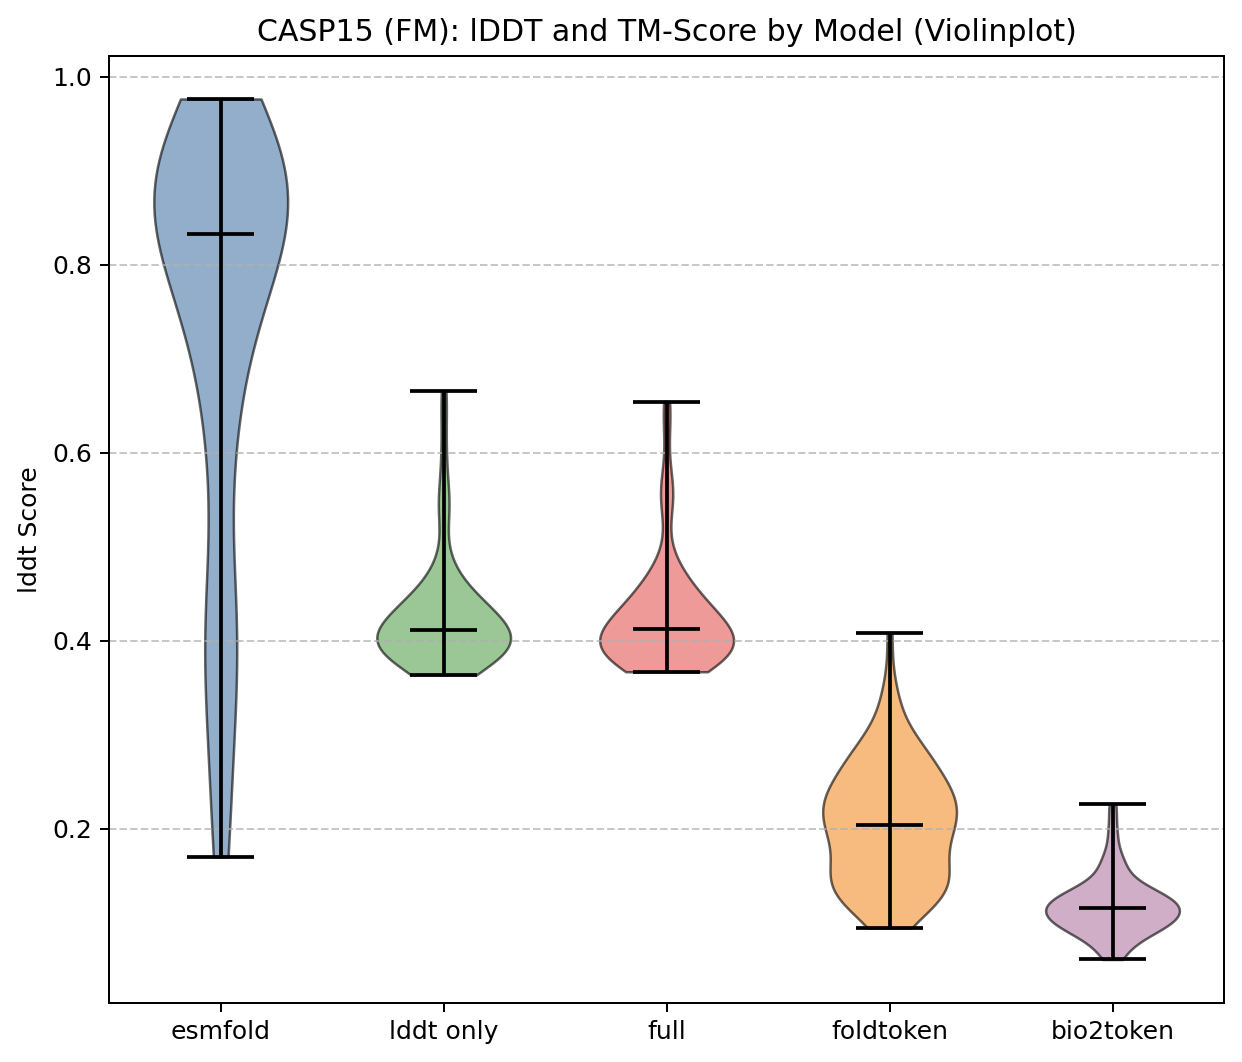

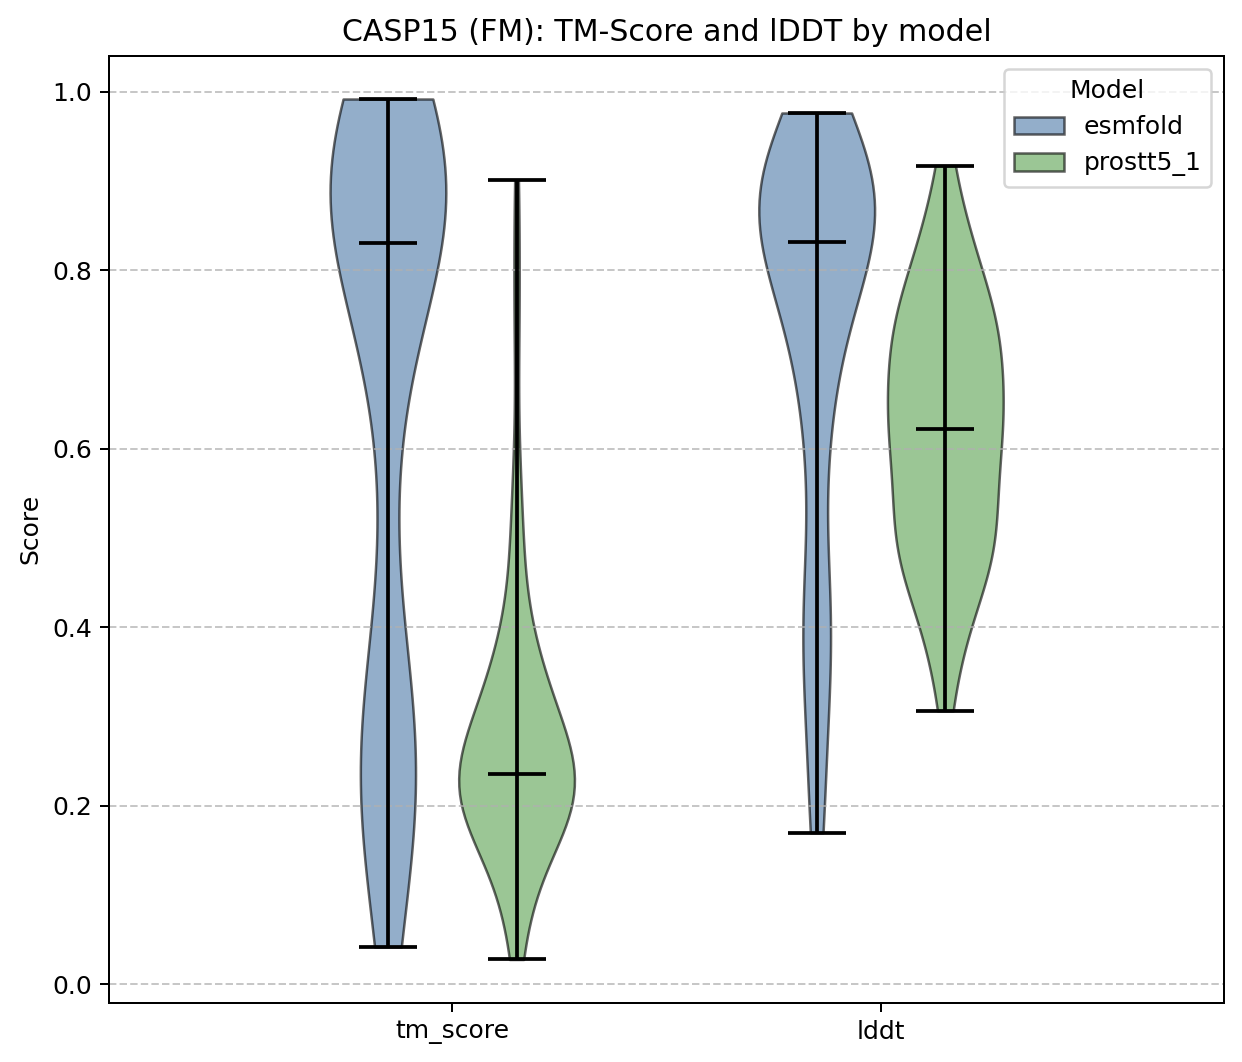

In [94]:
# CASP
casp_metrics = ['tm_score','lddt']
casp_dfs   = [esmfold_casp, beta_0_casp, beta_1_casp, foldtoken_casp, bio2token_casp]
casp_names = ["esmfold", "lddt only", "full", "foldtoken", "bio2token"]

# 1) Grouped-by-metric BOX
plot_scores(
    metrics=casp_metrics,
    dfs=casp_dfs,
    model_names=casp_names,
    kind="box",
    layout="by_metric",
    out_path="plots/final/casp_box_compare.png",
    title="CASP15 (FM): Scores by Model (Boxplots)"
)

# 2) Single metric (lDDT) BOX, models on x
plot_scores(
    metrics=['lddt'],
    dfs=casp_dfs,
    model_names=casp_names,
    kind="box",
    layout="single_metric",
    single_metric_name='lddt',
    fig=(7,6),
    out_path="plots/final/casp_box_lddt.png",
    title="CASP15 (FM): lDDT by Model (Boxplot)"
)

# 3) Grouped-by-metric VIOLIN
plot_scores(
    metrics=casp_metrics,
    dfs=casp_dfs,
    model_names=casp_names,
    kind="violin",
    layout="by_metric",
    out_path="plots/final/grouped_casp_violin_compare.png",
    title="CASP15 (FM): Scores by Model (Violinplots)"
)

# 4) Single metric (lDDT) VIOLIN, models on x
plot_scores(
    metrics=['lddt'],
    dfs=casp_dfs,
    model_names=casp_names,
    kind="violin",
    layout="single_metric",
    single_metric_name='lddt',
    fig=(7,6),
    out_path="plots/final/compare_casp_violin.png",
    title="CASP15 (FM): lDDT and TM-Score by Model (Violinplot)"
)

casp_dfs   = [esmfold_casp, prostt5_casp_1]
casp_names = ["esmfold", "prostt5_1"]

plot_scores(
    metrics=['tm_score','lddt'],
    dfs=casp_dfs,
    model_names=casp_names,
    kind="violin",
    layout="by_metric",
    fig=(7,6),
    out_path="plots/final/casp_violin_compare.png",
    title="CASP15 (FM): TM-Score and lDDT by model"
)

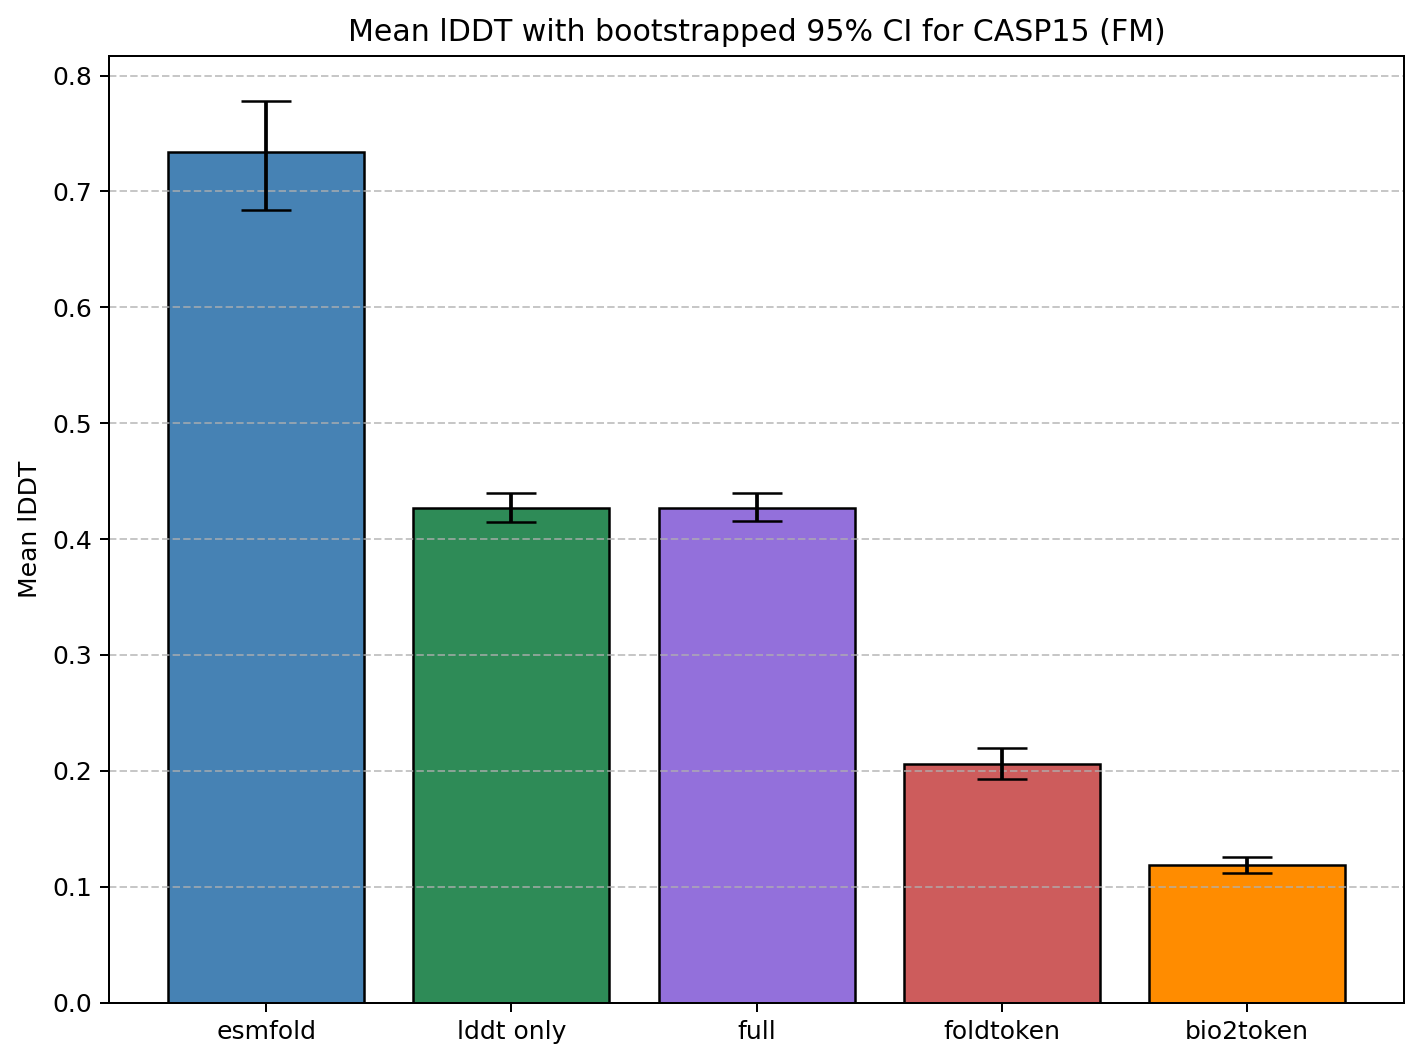

In [95]:
# Inputs you already have
dfs = [esmfold_casp, beta_0_casp, beta_1_casp, foldtoken_casp, bio2token_casp]
model_names = ["esmfold", "lddt only", "full", "foldtoken", "bio2token"]

metric = "lddt"  # <- no 'metrics' list needed

# Compute bootstrap CIs per model for the chosen metric
all_results = {}
for model_name, df in zip(model_names, dfs):
    data = df[metric].dropna().values
    mean, lower, upper = bootstrap_ci(data)   # assumes you already have this function
    all_results[model_name] = {metric: {"mean": mean, "lower_ci": lower, "upper_ci": upper}}

# Extract means and CI bounds
means     = [all_results[m][metric]["mean"]      for m in model_names]
lower_ci  = [all_results[m][metric]["lower_ci"]  for m in model_names]
upper_ci  = [all_results[m][metric]["upper_ci"]  for m in model_names]

# yerr expects a shape (2, N): [lower_errors, upper_errors]
yerr = np.vstack([
    np.array(means) - np.array(lower_ci),
    np.array(upper_ci) - np.array(means)
])

# Plot
x = np.arange(len(model_names))
plt.figure(figsize=(8, 6), dpi=180)

colors = ['steelblue','seagreen','mediumpurple','indianred','darkorange'][:len(model_names)]

plt.bar(
    x, means, yerr=yerr, capsize=10,
    color=colors, edgecolor='black'
)

plt.xticks(x, model_names)
plt.ylabel("Mean lDDT")
plt.title("Mean lDDT with bootstrapped 95% CI for CASP15 (FM)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/final/lddt_ci_per_model.png")
plt.show()
